In [110]:
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import time
import datetime

In [5]:
df = pd.read_csv('features.csv', index_col='match_id')

In [6]:
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [27]:
X = df[df.columns[:102]]
y = df['radiant_win']


# Подход 1: градиентный бустинг "в лоб"

###  1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [29]:
X.count()[X.count() != len(X)]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

In [30]:
# first_blood_time и first_blood_team имеют пропуски, потому что не во всех играх в отведенное время было совершено "Первое убийство" 
# Следовательно время первого убийства и команда, которое это сделала неизвестны => поле не заполнено

In [31]:
X = X.fillna(0)

### 2. Как называется столбец, содержащий целевую переменную?

In [14]:
# Целевая переменная содержится в столбце radiant_win

In [32]:
# Перемешаем выборку
X, y = shuffle(X, y)

In [72]:
n_estimators = [10,15,20,25,30,35,40]
results = []

for n in n_estimators:
    grad_boosting = GradientBoostingClassifier(n_estimators = n, random_state = None)
    
    start_time = datetime.datetime.now()
    result = cross_val_score(estimator = grad_boosting,cv = 5,  X = X, y = y, scoring = 'roc_auc')
    results.append([n,result.mean()])
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    

Time elapsed: 0:00:24.198052
Time elapsed: 0:00:35.756861
Time elapsed: 0:00:44.944616
Time elapsed: 0:00:53.379383
Time elapsed: 0:01:03.385112
Time elapsed: 0:01:13.286488
Time elapsed: 0:01:24.784190


In [73]:
res=pd.DataFrame(results, columns=['n_estimators','roc_auc'])
res

,n_estimators,roc_auc
0,10,0.665893
1,15,0.676102
2,20,0.682586
3,25,0.686682
4,30,0.689628
5,35,0.692092
6,40,0.694069


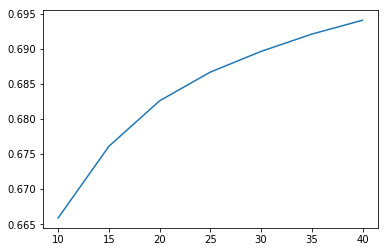

In [74]:
plt.plot(res['n_estimators'], res['roc_auc'])

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? 

In [ ]:
# Rросс-валидация для градиентного бустинга с 30 деревьями проводилась 0:01:03.385112, качество равно 0.689628

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

In [ ]:
#  Видно, что оптимум не достигнут, имеет смысл использовать больше чем 30 деревьев. Для ускорения обучения можно уменьшить глубину 
#  деревьев или же использовать для обучения не всю выборку. Так же можно уменьшить значение cv = 3. 

# Подход 2: логистическая регрессия

In [87]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [129]:
C_range = np.logspace(-3, 1, 5)
results_log_reg = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result_log_reg = cross_val_score(estimator = log_reg, cv = 5,  X = X_scaled, y = y, scoring = 'roc_auc')
    results_log_reg.append([c, result_log_reg.mean()])
    print ('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:08.657998
Time elapsed: 0:00:12.365267
Time elapsed: 0:00:12.812070
Time elapsed: 0:00:12.771174
Time elapsed: 0:00:12.732237


In [130]:
res_log_reg=pd.DataFrame(results_log_reg, columns=['C','roc_auc'])
res_log_reg

,C,roc_auc
0,0.001,0.716327
1,0.010,0.716500
2,0.100,0.716468
3,1.000,0.716462
4,10.000,0.716462


### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [ ]:
# Качество лог. регрессии луше, чем у бистинга. Лучшее значение roc_auc = 0.7165 при C = 0.01. Логисчтическая регрессия работает быстрее
# Качество выше, потому что для лог. регрессия требуется предобработки данных.

In [141]:
X_no_categorial = X.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1)

In [142]:
X_no_catehorial_scaled = scaler.fit_transform(X_no_categorial)

In [143]:
C_range = np.logspace(-3, 1, 5)
results_log_reg = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result_log_reg = cross_val_score(estimator = log_reg, cv = 5,  X = X_no_catehorial_scaled, y = y, scoring = 'roc_auc')
    results_log_reg.append([c, result_log_reg.mean()])
    print ('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:08.861473
Time elapsed: 0:00:11.155620
Time elapsed: 0:00:11.691921
Time elapsed: 0:00:11.724168
Time elapsed: 0:00:11.607300


In [144]:
res_log_reg=pd.DataFrame(results_log_reg, columns=['C','roc_auc'])
res_log_reg

,C,roc_auc
0,0.001,0.716338
1,0.010,0.716515
2,0.100,0.716486
3,1.000,0.716482
4,10.000,0.716482


### 2.  Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

In [ ]:
# Качество классификации немного увеличилось до 0.716515. Это связано с тем, что были удалены категориальные признаки, 
# которые нельзя сравнивать между собой

In [228]:
columns = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

In [237]:
heroes = []
for i in columns:
    a = X[i].unique().tolist()
    heroes.extend(a)

In [240]:
# Количество героев
len(set(heroes))

108

In [246]:
data = X

In [248]:
X_pick = np.zeros((data.shape[0], len(set(heroes))))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-5] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-5] = -1

In [267]:
X_concat = np.concatenate([X_no_catehorial_scaled, X_pick], axis=1)

In [268]:
C_range = np.logspace(-3, 1, 5)
results_log_reg = []

for c in C_range:
    log_reg = LogisticRegression(penalty='l2', C = c)
    
    start_time = datetime.datetime.now()
    result_log_reg = cross_val_score(estimator = log_reg, cv = 5,  X = X_concat, y = y, scoring = 'roc_auc')
    results_log_reg.append([c, result_log_reg.mean()])
    print ('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:09.851530
Time elapsed: 0:00:16.264756
Time elapsed: 0:00:24.607187
Time elapsed: 0:00:27.811352
Time elapsed: 0:00:30.061577


In [269]:
res_log_reg=pd.DataFrame(results_log_reg, columns=['C','roc_auc'])
res_log_reg

,C,roc_auc
0,0.001,0.744683
1,0.010,0.749684
2,0.100,0.749895
3,1.000,0.749866
4,10.000,0.749859


In [270]:
# Наилучшее качество 0.749895 при С = 0.1